# La (semi-)complétion automatique

### Table des matières:
* [Les approches utilisées](#appproches)
    * [Introduction](#introduction)
    * [Histoire](#histoire)
    * [Par dictionnaire](#dictionnaire)
    * [Par mot précememment saisis](#predemment-saisis)
    * [Par les caratères de l'application](#caractere-application)
    * [Par sémantique](#semantique)
        * [Intelligence Artificielle](#intelligence-artificielle)
        *[Algorithme type GPT-3](#intelligence-artificielle-GPT3)
* [Les algorithmes de calculs de distance](#calcul-distance)

## Les approches utilisées <a class="anchor" id="appproches"></a>

### Introduction <a class="anchor" id="introduction"></a>

La semi-complétion automatique est une fontionnalitée informatique permettant a l'utilisateur de limiter la quantité d'information qu'il saisies avec son clavier , en se voyant proposer un complément qui pourrait convenir avec la chaine de caractères qu'il a commancé a saisir.

La semi-complétion automatique a pour but de simplifier la tâche d'écriture de l'utilisateur.
On peux citer des exemples dans lesquels ces algorithmes sont utilisées :

* La complétion dans la recherches sur les navigateurs
* La complétions des mots dans les messages textes
* Dans l'écriture de code informatique
* Dans les mails

Dans cette présentation on se concentretas sur la semi-completion automatique des messges textes écrits par nos téléphones.

### Un peu d'histoire <a class="anchor" id="histoire"></a>

L’histoire des correcteurs automatiques a commencé chez Microsoft au début des années 90.
Le logiciel ne disposait que d'un "autoexpander", des racourcis clavier pour écrire un mot pré-enregistrée.

**Dean Hachamovitch** S'est inspiré de ce système pour créer le premier correcteur orthographique qui remplaçait les "teh" par "the"

Lui et son équipe ont vu que c'était une idée interéssante et ont décidés de develloper cette iddée en créant des dictionnaires qui remplaçait un mot mal orthographié par le mot correctement ortographié.

C'est ainsi qu'est apparue la première approche que nous allons détailler: l'approche par dictionnaire.

### Par dictionnaire <a class="anchor" id="dictionnaire"></a>

La (semi-)complétion automatique par dictionnaire est le première approche a avoir été utilisée sur téléphone.
Elle est la plus simple, est la plus rapide avec peu de puissance si on a les bons dictionnaires.

Elle a été utiliser sur les télephones **T9** qui sont des téléphones avec peu de puissance de calculs.
Sur ces téléphonezs on disposait de 9 touches pour un alphabet de 26 lettres.

Plusieurs lettres étaient sur la même touche ce qui ralentissait l'écriture.
Pour acceder a la touche c par exemple il fallait appuyer 3 fois sur la touche 1.

C'est de là qu'est né le language sms.
Il a donc fallut ajouter un autocompleteur pour écrire des mots complet sans pour autant avoir a appyer sur 50 touches.

### Par mot précememment saisis <a class="anchor" id="predemment-saisis"></a>

Les suggestions données à l'utilisateur peuvent se baser sur son propre vocabulaire.
En effet on peut supposer que l'utilisateur sera amené à réutiliser des mots qu'il a déjà utilisé, la question sera donc de déterminer quels sont les mots qu'il réutilisera à l'avenir.

En moyenne une personne française utilise entre 300 et 5000 mots sur 32000 mots courrament utilisée.

On peux donc se servir de ces statistiques pour avoir des dictionnaires plus petit (et donc avoir une recherche plus rapide) pour faire les corrections avec l'approche précédente.

Cependant, connaissant les mot que la personnes utilise, on peut rechercher et afficher en priorité ces mots

Mais cela pose un problème qui est la gestion des données et de la vie privée qui est aux coeur des débats en 2022.
Il faut donc prendre cette approche avec des pincettes.

### Par les caratères de l'application <a class="anchor" id="caractere-application"></a>

Certains termes ne sont utilisés que dans certains cas comme par exemple une adresse mail.
Certains ne se trouvent pas dans le dictionnaire et donc un logiciel de complétion (semi-)automatique aura des difficultés à les corriger.

On peux donc choisir d'ajouter des paramètres de l'application comme mots fesant partit du dictionnaire

On peux prendre l'exemple des adresses mail dans un logiciel de méssagerie.
Ou encore, les noms des contacts dans une application de messages pour téléphones.

Cela permet de gagner en éfficacité et de ne pas corriger des mots qui ne doivent pas l'être.
Comme cité précédemment, lorsqu'on veux citer une personne on veux que le correcteur donne le bon nom et ne le corrige pas selon un mot dans le dictionnaire.

### Par sémantique <a class="anchor" id="semantique"></a>

Avec l'amélioration de la puissance et de la mémoire du matériel, les possibilitées pour rendre la complétion automatique plus éfficacces s'est aggrandie.
Les approches ci-dessus permettent une complétion semi-automatique correct mais on peux allez plus loing.

Dans cette partie, on verra quelles approches ont découlé de cette augmentation de puissances.

#### Intelligence Artificielle <a class="anchor" id="intelligence-artificielle"></a>

Une nouvelle approche qui a fait surface depuis quelques années est celle de l'intelligence artificielle.
Le principe est d'entrainer une structure matémétique a produire un résultat par rapport a des entrées spécifiques.

La complexité avec une langue est que la combinaison des mots est infinie, c'est donc un problème très compliqué a résoudre.
De plus il faut une trés grande base de données et l'algorithme n'est pas adaptatif.

Une fois l'algorithme entrainée, il devient difficile de lui faire changer ses réponses.
De plus, des problèmes sur les types d'entrées et de sorties se posent:
* Faut-il prendre des mots en entrées et sortie, alors le programme ne pourras pas utiliser de nouveaux mots ou il faut le réentrainer constamment.
* Faut-il prendre des lettres, mais alors les résultas serons moin précis et les mots produits n'éxistent peux être pas.

Des questions qui sont compliquées a répondre.

#### Algorithme type GPT-3 <a class="anchor" id="intelligence-artificielle-GPT3"></a>

L'algorithme GPT est développé par *Open IA*.
Ajourd'hui l'un des meilleur completeur automatique de phrases (voir plus).

Leur algorithme utilise l'intéligence artificielle comme citée ci-dessus, mais il ont une différence importante.
Cet algorithme va tenter de classifier les mots avant de les envoyer dans le réseau de neurones.

On va ainsi pouvoir classer les différents types de mots comme:
    * Les mots qui ne portent pas de sens comme les: de, la, les, ou, etc.
    * Les mots qui correspondent a des organisations, les noms de personnes.
    * Les verbes, les adjectifs, etc.
Tous cela va permettre ensuite au réseau neronal de comprendre les sens et de comprendre la phrase.

Le fait de comprendre la phrase va donc permettre de produire le mot suivant, la fin de la phrase ou plus.
L'algorithme GPT peux rédiger un paragraphe complet en partant de quelques lignes de contexte ou peux produire un texte selons les recommandations que vous lui faites.

Cette algorithme est devenu si puissant qu'il est intégré a d'autres logiciels de complétion automatique voir de jeux.
On peut citer parmit les logiciels qui l'utilise:
* IA Dongeon
* Github copilot
* Des chatbots

## Les algorithmes de calculs de distance <a class="anchor" id="calcul-distance"></a>

### Setup

In [1]:
%load_ext lab_black
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import pandas as pd
import data.background as utils
import random

utils.setWidgetTextSize(2)

In [2]:
filename = "data/liste.de.mots.francais.frgut.csv"
#Lien vers le site qui nous a permis d'avoir la base de donnée http://www.pallier.org/liste-de-mots-francais.html

word_dict = utils.import_data(filename)
word_dict = utils.delete_useless_word_in_pd(word_dict)

utils.getPredictions = utils.getPredictionsFromDict(word_dict)
utils.getPredictionParamFunct = utils.getPredictionsFromDictForPreParamFunction(
    word_dict
)

print("Nombre de mots dans le dictionnaire: ", len(word_dict))

TestWord = "abouhcemsnr"

IntProgress(value=0, description='Loading:', max=4, style=ProgressStyle(bar_color='blue'))

Nombre de mots dans le dictionnaire:  336437


### Distance de Levenstein

Cet algorithme permet de calculer la distance entre deux mots.
Il n'as que 3 opérations de base qui sont:
* l'ajout
* la supperssion
* la substitution

On construit un tableau avec ces règles et pour chaque opérartions on ajoute 1 a la case.

<div>
<img src="attachment:cb1e79f6-2fe5-422a-9636-7e455b2d0cef.png" alt="distance de levenstein" title="distance de levenstein" width="500" height="500">
</div>

In [3]:
def DistanceDeLevenshtein(c1, show_table=False):

    width = len(c1) + 1

    def funct(c2):
        D = []
        height = len(c2) + 1
        for i in range(0, height):
            D.append([0] * width)
            D[i][0] = i
        for j in range(1, width):
            D[0][j] = j

        for i in range(1, height):
            for j in range(1, width):
                coutSubtitution = 1
                if c1[j - 1] == c2[i - 1]:
                    coutSubtitution = 0
                D[i][j] = min(
                    D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + coutSubtitution
                )
        if show_table:
            utils.showLevensteinTable("Tableau de Levenshtein", c1, c2, D)

        return D[-1][-1]

    return funct

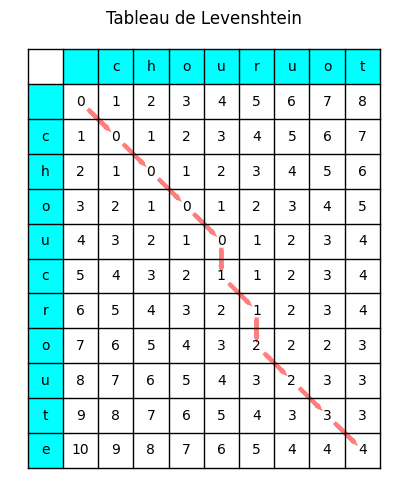

4

In [4]:
DistanceDeLevenshtein("chouruot", show_table=True)("choucroute")

In [5]:
pred, time_elapsed = utils.getPredictions(DistanceDeLevenshtein, TestWord, TestWord[:2])
print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeLevenshtein.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeLevenshtein as mis 0.599897 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
851  abouchement         4
936   aboutement         4
562    aboiement         5


### Distance Damerau-Levenstein

Cet algorithme reprend les mêmes opérations que celui de levenstein mais implémente aussi inversion entre deux lettres cote à cote.
Toutes ces opérations correspondent a 80% des fautes d'orthographes humaines.

In [6]:
def DistanceDeDamerauLevenshtein(c1, show_table=False):

    width = len(c1) + 1

    def funct(c2):
        D = []
        height = len(c2) + 1
        for i in range(0, height):
            D.append([0] * width)
            D[i][0] = i
        for j in range(1, width):
            D[0][j] = j

        for i in range(1, height):
            for j in range(1, width):
                coutSubtitution = 1
                if c1[j - 1] == c2[i - 1]:
                    coutSubtitution = 0
                D[i][j] = min(
                    D[i - 1][j] + 1, D[i][j - 1] + 1, D[i - 1][j - 1] + coutSubtitution
                )
                if (
                    i > 0
                    and j > 0
                    and c1[j - 1] == c2[i - 2]
                    and c1[j - 2] == c2[i - 1]
                ):
                    D[i][j] = min(D[i][j], D[i - 2][j - 2] + coutSubtitution)
        if show_table:
            utils.showLevensteinTable("Tableau de Damerau-Levenshtein", c1, c2, D)
        return D[-1][-1]

    return funct

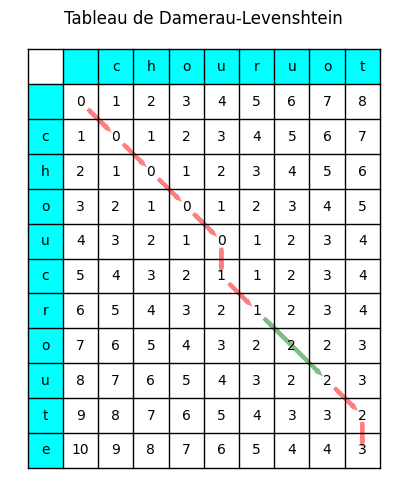

3

In [7]:
DistanceDeDamerauLevenshtein("chouruot", show_table=True)("choucroute")

In [8]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeDamerauLevenshtein, TestWord, TestWord[:2]
)

print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeDamerauLevenshtein.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeDamerauLevenshtein as mis 0.501628 secondes pour s'executer
Prediction for word:  abouhcemsnr
            ortho  affinity
851   abouchement         3
852  abouchements         4
853     abouchent         4


### Distance de Jaro


In [9]:
def DistanceDeJaro(c1, show_table=False):
    len_c1 = len(c1)

    def funct(c2):
        len_c2 = len(c2)
        if c1 == c2:
            return 1
        limit = int(max(len_c1, len_c2) / 2) - 1
        match = 0
        c1_match = [0] * len_c1
        c2_match = [0] * len_c2
        for i in range(len_c1):
            for j in range(max(0, i - limit), min(len_c2, i + limit + 1)):
                if c1[i] == c2[j] and not c2_match[j]:
                    c1_match[i], c2_match[j] = 1, 1
                    match += 1
                    break

        if show_table:
            utils.showJaroTable("Table de Jaro", c1, c2)
        if match == 0:
            return 0
        t = 0
        point = 0
        for i in range(len_c1):
            if c1_match[i]:
                while not c2_match[point]:
                    point += 1
                if c1[i] != c2[point]:
                    t += 1
                point += 1
        t /= 2
        return (
            (match / float(len_c1))
            + (match / float(len_c2))
            + ((match - t) / float(match))
        ) / 3.0

    return funct

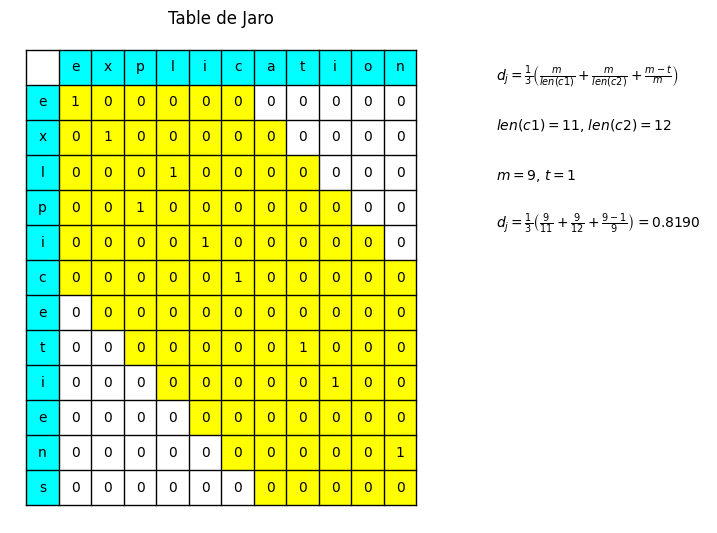

0.8190235690235691

In [10]:
DistanceDeJaro("explication", show_table=True)("exlpicetiens")

In [11]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeJaro, TestWord, TestWord[:2], mofier_funct=lambda x: 1 - x
)

print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeJaro.__name__), time_elapsed
    )
)

print("Prediction for word: ", TestWord)
print(pred)

DistanceDeJaro as mis 0.472085 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
865  aboucherons  0.127273
854     aboucher  0.132576
867     abouches  0.132576


### Distance de Jaro-Winker


In [12]:
def DistanceDeJaroWinkler(c1, threshold=0.7, p=0.1, show_table=False):
    fDistanceDeJaro = DistanceDeJaro(c1)

    def funct(c2):
        dj = fDistanceDeJaro(c2)

        l = 0
        pos = 0
        if dj > threshold:
            for i in range(min(len(c1), len(c2))):
                if c1[l] != c2[l]:
                    break
                if l >= 4:
                    break
                l += 1

        if show_table:
            utils.showJaroTable(
                "Table de Jaro-Winkler",
                c1,
                c2,
                Winkler=True,
                p=p,
                threshold=threshold,
                l=l,
            )

        return dj + (l * p * (1 - dj))

    return funct

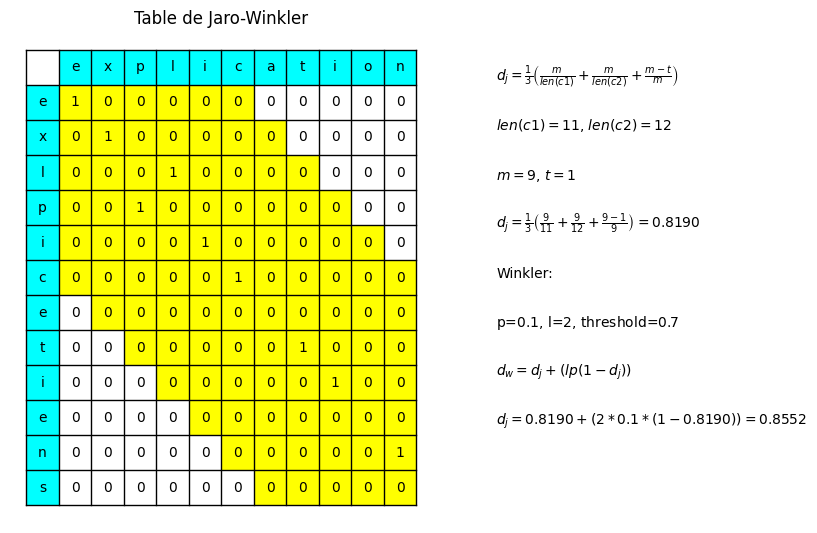

0.8552188552188553

In [13]:
DistanceDeJaroWinkler("explication", show_table=True)("exlpicetiens")

In [14]:
pred, time_elapsed = utils.getPredictions(
    DistanceDeJaroWinkler, TestWord, TestWord[:2], mofier_funct=lambda x: 1 - x
)
print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeJaroWinkler.__name__), time_elapsed
    )
)
print("Prediction for word: ", TestWord)
print(pred)

DistanceDeJaroWinkler as mis 0.494885 secondes pour s'executer
Prediction for word:  abouhcemsnr
           ortho  affinity
865  aboucherons  0.076364
854     aboucher  0.079545
867     abouches  0.079545


In [15]:
utils.displayComparaisonInterface(
    utils.getPredictions,
    DistanceDeLevenshtein,
    DistanceDeDamerauLevenshtein,
    DistanceDeJaro,
    DistanceDeJaroWinkler,
)

Text(value='', _dom_classes=('custom-size',))

GridspecLayout(children=(Label(value='Levenshtein', layout=Layout(grid_area='widget001'), _dom_classes=('custo…

### Nos modifications

In [16]:
def DamerauLevenshteinReglable(
    c1, costAdd=1, costSuppr=1, costSubst=1, costTransp=1, multProxi=1
):
    width = len(c1) + 1

    def funct(c2):
        D = []
        height = len(c2) + 1
        for i in range(0, height):
            D.append([0] * width)
            D[i][0] = i
        for j in range(1, width):
            D[0][j] = j

        for i in range(1, height):
            for j in range(1, width):
                coutSubtitution = 1
                if c1[j - 1] == c2[i - 1]:
                    coutSubtitution = 0
                elif c2[i - 1] in utils.azerty_around_letter[c1[j - 1]]:
                    coutSubtitution *= multProxi
                D[i][j] = min(
                    D[i - 1][j] + costSuppr,
                    D[i][j - 1] + costAdd,
                    D[i - 1][j - 1] + coutSubtitution * costSubst,
                )
                if (
                    i > 0
                    and j > 0
                    and c1[j - 1] == c2[i - 2]
                    and c1[j - 2] == c2[i - 1]
                ):
                    D[i][j] = min(
                        D[i][j], D[i - 2][j - 2] + coutSubtitution * costTransp
                    )
        return D[-1][-1]

    return funct

In [17]:
DamerauLevenshteinReglable(
    "retame", costAdd=1, costSuppr=1, costSubst=1, costTransp=1, multProxi=1
)("ertame")

1

In [18]:
TestWord = "chouruot"
pred, time_elapsed = utils.getPredictionParamFunct(
    DamerauLevenshteinReglable(
        TestWord, costAdd=2, costSuppr=2, costSubst=1, costTransp=2, multProxi=2
    ),
    TestWord[:2],
)
print(
    "{0} as mis {1:f} secondes pour s'executer".format(
        (DistanceDeJaroWinkler.__name__), time_elapsed
    )
)
print("Prediction for word: ", TestWord)
print(pred)

DistanceDeJaroWinkler as mis 1.577250 secondes pour s'executer
Prediction for word:  chouruot
          ortho  affinity
52113  chourava         3
52128  chourave         3
52130  chouravé         3


### Chaine de markov

In [19]:
with open("data/train_text.txt", "r") as f:
    data = f.read()
sentences = utils.data_file_to_sentences(data)

max_order = 5
markov_model = []
for i in range(max_order):
    markov_model.append(dict())

pbar = utils.create_progress_bar_training_markov(sentences)

for s in sentences:
    words = s.split(" ")
    words = utils.remove_empty_words(words)
    if len(words) == 0:
        continue
    for i in range(len(words)):
        for j in range(0, min(i, max_order)):
            utils.update_occ(
                markov_model[j],
                " ".join([words[i - k] for k in range(j + 1, 0, -1)]),
                words[i],
            )
    pbar.value += len(words)

8280


IntProgress(value=0, bar_style='info', description='Create markov model:', max=8280, style=ProgressStyle(bar_c…

In [20]:
text = random.choice(list(markov_model[max_order - 1].keys()))
# text = "mais ne boudons pas"

print(text)
text = text.split(" ")
text_len = len(text)
for i in range(min(len(text), max_order), 0, -1):
    t = " ".join(text[-i:])
    print("Chaine de markov d'ordre {}: {}".format(i, t))
    if t in markov_model[i - 1].keys():
        s = sorted(markov_model[i - 1][t].items(), key=lambda item: item[1])
        total = sum(markov_model[i - 1][t].values())
        for j in range(0, min(len(s), 5)):
            print("{} : {:.2f}%".format(s[j][0], (s[j][1] / total) * 100))
    else:
        print("Aucune proposition disponible")
    print()

agglomération de montpellier la choisit
Chaine de markov d'ordre 5: agglomération de montpellier la choisit
pour : 100.00%

Chaine de markov d'ordre 4: de montpellier la choisit
pour : 100.00%

Chaine de markov d'ordre 3: montpellier la choisit
pour : 100.00%

Chaine de markov d'ordre 2: la choisit
pour : 100.00%

Chaine de markov d'ordre 1: choisit
le : 50.00%
pour : 50.00%



In [21]:
# generate at most 100 words:
for i in range(200):

    last_idx = text_len - 1

    tmp = text[last_idx - 1] + " " + text[last_idx]
    if tmp in markov_model[1]:
        new_word = utils.gen_random_from_tbl(markov_model[1][tmp])
    else:
        # fall-back to 1st order
        tmp2 = text[last_idx]
        if tmp2 not in markov_model[0]:
            # dead-end
            break
        new_word = utils.gen_random_from_tbl(markov_model[0][tmp2])

    text.append(new_word)
    text_len = text_len + 1

print(" ".join(text))

agglomération de montpellier la choisit pour réaliser le design de sa femme dans la foulée
